In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, HTML
import matplotlib.ticker as mtick
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

sns.set()

In [2]:
df = pd.read_csv("holding_period/holding_period.csv")

df = df.drop_duplicates(subset=["title", "summary", "time_published", "symbol"], keep="first")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86125 entries, 0 to 86536
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            86125 non-null  int64  
 1   title                            86125 non-null  object 
 2   url                              86125 non-null  object 
 3   time_published                   86125 non-null  object 
 4   authors                          86125 non-null  object 
 5   summary                          86124 non-null  object 
 6   banner_image                     85327 non-null  object 
 7   source                           86125 non-null  object 
 8   category_within_source           19891 non-null  object 
 9   source_domain                    86125 non-null  object 
 10  topics                           86125 non-null  object 
 11  overall_sentiment_score          86125 non-null  float64
 12  overall_sentiment_

In [34]:
relevant_df = df.loc[df["relevance_score"] > 0.5]
print(len(relevant_df))

33318


## Correlation

### Lexicon - score -> label

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

### Finbert - label probability 
- Negative: p1
- Neutral: p2
- Positive: p3

p1+p2+p3=1

Label an article as pos/neg only if the probablity is higher than the threshold (0.8)

### Stock price - percentage return

- 25th percentile: negative 
- 75th percentile: positive



### Analysis

To simplify the multi-class classification problem, we transform this into a binary classification problem.

Firstly, we remove neutral price movements since we are not interested in predicting this specific event.

For news articles which has significant price movement (absolute percentage return bigger than x% in the specified time window), we feed into the lexicon-based and model-based sentiment analysis algorithm.

The algorithm will classify them into three classes (positive, neutral, negative). We remove articles labelled as neutral by the algorithm and evaluate its accuracy on positive or negative articles.

## target

In [5]:
def return_dist(df, pct_return_col):
    # 75th percentile as positive threshold 
#     pos_threshold = 0.002
    pos_threshold = df[pct_return_col].quantile(0.75)
    print(f"Positive threshold: {pos_threshold:.3f}")
    
    # 25th percentile as negative threshold
#     neg_threshold = -0.002    
    neg_threshold = df[pct_return_col].quantile(0.25)
    print(f"Negative threshold: {neg_threshold:.3f}")
        
    # neutral 
    neutral_count = len(df.loc[(df[pct_return_col] > neg_threshold) & (df[pct_return_col] < pos_threshold)])

    # positive
    pos_count = len(df.loc[df[pct_return_col] > pos_threshold])

    # negative
    neg_count = len(df.loc[df[pct_return_col] < neg_threshold])

    print(f"Positive: {pos_count} \nNegative: {neg_count} \nNeutral: {neutral_count}")

In [6]:
holding_period_list = ["30_minutes", "1_hour", "1_day", "5_day"]
    
for hp in holding_period_list:
    print(hp)
    print(relevant_df[f"pct_return_{hp}"].describe())
    print(abs(relevant_df[f"pct_return_{hp}"]).describe())
    return_dist(relevant_df, pct_return_col=f"pct_return_{hp}")
    
    print("\n")

30_minutes
count    33318.000000
mean         0.000156
std          0.008383
min         -0.144232
25%         -0.003015
50%          0.000007
75%          0.003371
max          0.459123
Name: pct_return_30_minutes, dtype: float64
count    33318.000000
mean         0.005100
std          0.006655
min          0.000000
25%          0.001245
50%          0.003194
75%          0.006714
max          0.459123
Name: pct_return_30_minutes, dtype: float64
Positive threshold: 0.003
Negative threshold: -0.003
Positive: 8330 
Negative: 8330 
Neutral: 16658


1_hour
count    33318.000000
mean         0.000229
std          0.009334
min         -0.136003
25%         -0.003622
50%          0.000119
75%          0.004020
max          0.459123
Name: pct_return_1_hour, dtype: float64
count    33318.000000
mean         0.005865
std          0.007264
min          0.000000
25%          0.001547
50%          0.003846
75%          0.007825
max          0.459123
Name: pct_return_1_hour, dtype: float64
Positive

In [7]:
def create_target_label(df, holding_period_list):
    df = df.copy()
    thres_list = []
    for hp in holding_period_list:
        print(hp)
        pct_return_col = f"pct_return_{hp}"
        
        # 75th percentile as positive threshold 
#         pos_threshold = 0.002
        pos_threshold = df[pct_return_col].quantile(0.75)
        print(f"Positive threshold: {pos_threshold:.3f}")

        # 25th percentile as negative threshold
        # neg_threshold = -0.002    
        neg_threshold = df[pct_return_col].quantile(0.25)
        print(f"Negative threshold: {neg_threshold:.3f}")
     
        # create a list of our conditions
        conditions = [
            (df[pct_return_col] > neg_threshold) & (df[pct_return_col] < pos_threshold),
            df[pct_return_col] >= pos_threshold,
            df[pct_return_col] <= neg_threshold,
            ]

        # create a list of the values we want to assign for each condition
        values = ['neu', 'pos', 'neg']

        # create a new column and use np.select to assign values to it using our lists as arguments
        df[f'target_label_{hp}'] = np.select(conditions, values)

        print(df[f'target_label_{hp}'].value_counts())
        print()
        
        thres_list.append([hp, pos_threshold, neg_threshold])
    
    thres_df = pd.DataFrame(thres_list, columns=["holding_period", "pos_threshold", "neg_threshold"])
    
    return df, thres_df

target_df, thres_df = create_target_label(relevant_df, holding_period_list)

30_minutes
Positive threshold: 0.003
Negative threshold: -0.003
neu    16658
pos     8330
neg     8330
Name: target_label_30_minutes, dtype: int64

1_hour
Positive threshold: 0.004
Negative threshold: -0.004
neu    16658
pos     8330
neg     8330
Name: target_label_1_hour, dtype: int64

1_day
Positive threshold: 0.013
Negative threshold: -0.012
neu    16657
neg     8331
pos     8330
Name: target_label_1_day, dtype: int64

5_day
Positive threshold: 0.027
Negative threshold: -0.024
neu    16658
pos     8330
neg     8330
Name: target_label_5_day, dtype: int64



In [8]:
thres_df.style.format({
    'pos_threshold': '{:.2%}'.format,
    'neg_threshold': '{:.2%}'.format,
})

,holding_period,pos_threshold,neg_threshold
0,30_minutes,0.34%,-0.30%
1,1_hour,0.40%,-0.36%
2,1_day,1.30%,-1.18%
3,5_day,2.70%,-2.43%


## lexicon

In [9]:
def create_lexicon_label(target_df):
    # create a list of our conditions
    conditions = [
        (target_df["lexicon_compound"] > -0.05) & (target_df["lexicon_compound"] < 0.05),
        target_df["lexicon_compound"] >= 0.05,
        target_df["lexicon_compound"] <= -0.05,
        ]

    # create a list of the values we want to assign for each condition
    values = ['neu', 'pos', 'neg']

    # create a new column and use np.select to assign values to it using our lists as arguments
    target_df['lexicon_label'] = np.select(conditions, values)

    target_df['lexicon_label'].value_counts()
    
    return target_df

target_df = create_lexicon_label(target_df)
target_df['lexicon_label'].value_counts()

neu    22454
pos     6547
neg     4317
Name: lexicon_label, dtype: int64

## finbert 

In [10]:
def classify_prob(s, pos_col, neg_col, prob_threshold):
    if s[pos_col] > prob_threshold:
        return 'pos'
    elif s[neg_col] > prob_threshold:
        return 'neg'
    else:
        return 'neu'

target_df["finbertv1_label"] = target_df.apply(classify_prob, pos_col='finbertv1_positive', neg_col='finbertv1_negative', prob_threshold=0.8, axis=1)    

print("finbertv1")
print(target_df["finbertv1_label"].value_counts())

target_df["finbertv2_label"] = target_df.apply(classify_prob, pos_col='finbertv2_Positive', neg_col='finbertv2_Negative', prob_threshold=0.8, axis=1)    

print("finbertv2")
print(target_df["finbertv2_label"].value_counts())

finbertv1
neu    16165
pos    11503
neg     5650
Name: finbertv1_label, dtype: int64
finbertv2
neu    15176
pos    11544
neg     6598
Name: finbertv2_label, dtype: int64


In [11]:
# transform multiclass probability to a feature score
target_df["finbertv1_compound"] = -1*target_df["finbertv1_negative"] + 1* target_df["finbertv1_positive"]
target_df["finbertv2_compound"] = -1*target_df["finbertv2_Negative"] + 1* target_df["finbertv2_Positive"]

## Result

### Classification

In [14]:
def get_result(target_df, report=False, matrix=False, debug=False):
    rows = []
    for hp in holding_period_list:
        print(hp)
        target_label_col = f'target_label_{hp}'
        target_filter_df = target_df.loc[target_df[target_label_col].isin(["pos", "neg"])].copy()
        print(target_filter_df[target_label_col].value_counts())
        for feature_col in ['lexicon_label', "finbertv1_label", "finbertv2_label"]:
            print(feature_col)
            feature_filter_df = target_filter_df.loc[target_filter_df[feature_col].isin(["pos", "neg"])]
            
            # classification report
            if report:
                print(classification_report(feature_filter_df[target_label_col], feature_filter_df[feature_col]))

            # confusion matrix
            if matrix:
                cm = confusion_matrix(feature_filter_df[target_label_col], feature_filter_df[feature_col], labels=["neg", "pos"])
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
                disp.plot()
                plt.show()

            # summary table
            report_dict = classification_report(feature_filter_df[target_label_col], feature_filter_df[feature_col], output_dict=True)
            if debug: 
                print(feature_filter_df[feature_col].value_counts())
                print(report_dict)
            neg_prec = report_dict['neg']['precision']
            neg_support = report_dict['neg']['support']
            pos_prec = report_dict['pos']['precision']
            pos_support = report_dict['pos']['support']
            acc = report_dict['accuracy']

            rows.append([hp, feature_col, neg_prec, pos_prec, neg_support, pos_support, acc])

        print()

    #  summary
    feature_order = ["lexicon_label", "finbertv1_label", "finbertv2_label"] 
    metric_order = ["accuracy", "pos_prec", "neg_prec", "pos_support", "neg_support"]

    summary_df = (pd.DataFrame(rows, columns=["holding_period", "feature", "neg_prec", "pos_prec", "neg_support", "pos_support", "accuracy"])
     .set_index(["holding_period", "feature"])
     .unstack("feature")
     .reindex(index=["30_minutes", "1_hour", "1_day", "5_day"], columns=[(metric, feature) for metric in metric_order for feature in feature_order])
    )
    
    summary_df.columns.names = ["metric", "feature"]
    
    return summary_df

source = ['The Street', 'Others', 'Associated Press', 'CNBC', 'Reuters', 'GlobeNewswire', 'Wall Street Journal']
summary_df = get_result(target_df.loc[target_df["source"].isin(source)], report=False, matrix=False)

30_minutes
pos    537
neg    492
Name: target_label_30_minutes, dtype: int64
lexicon_label
finbertv1_label
finbertv2_label

1_hour
pos    538
neg    487
Name: target_label_1_hour, dtype: int64
lexicon_label
finbertv1_label
finbertv2_label

1_day
pos    555
neg    554
Name: target_label_1_day, dtype: int64
lexicon_label
finbertv1_label
finbertv2_label

5_day
neg    550
pos    542
Name: target_label_5_day, dtype: int64
lexicon_label
finbertv1_label
finbertv2_label



In [15]:
summary_df

metric              accuracy                                      pos_prec  \
feature        lexicon_label finbertv1_label finbertv2_label lexicon_label   
holding_period                                                               
30_minutes          0.512064        0.538298        0.580972      0.549708   
1_hour              0.528351        0.526205        0.560396      0.565714   
1_day               0.468672        0.479612        0.492806      0.510526   
5_day               0.437198        0.435039        0.465291      0.479532   

metric                                              neg_prec                  \
feature        finbertv1_label finbertv2_label lexicon_label finbertv1_label   
holding_period                                                                 
30_minutes            0.571429        0.587189      0.480198        0.504310   
1_hour                0.586498        0.579861      0.497653        0.466667   
1_day                 0.511450        0.492163      0.430622        0.446640   
5_day                 0.480687        0.503472      0.407407        0.396364   

metric                           pos_support                                  \
feature        finbertv2_label lexicon_label finbertv1_label finbertv2_label   
holding_period                                                                 
30_minutes            0.572770           199             251             256   
1_hour                0.534562           206             267             268   
1_day                 0.493671           216             274             277   
5_day                 0.420408           226             278             287   

metric           neg_support                                  
feature        lexicon_label finbertv1_label finbertv2_label  
holding_period                                                
30_minutes               174             219             238  
1_hour                   182             210             237  
1_day                    183             241             279  
5_day                    188             230             246

## Mean Accuracy and Precision

(array([0, 1, 2]),
 [Text(0, 0, 'Accuracy'),
  Text(1, 0, 'Positive Precision'),
  Text(2, 0, 'Negative Precision')])

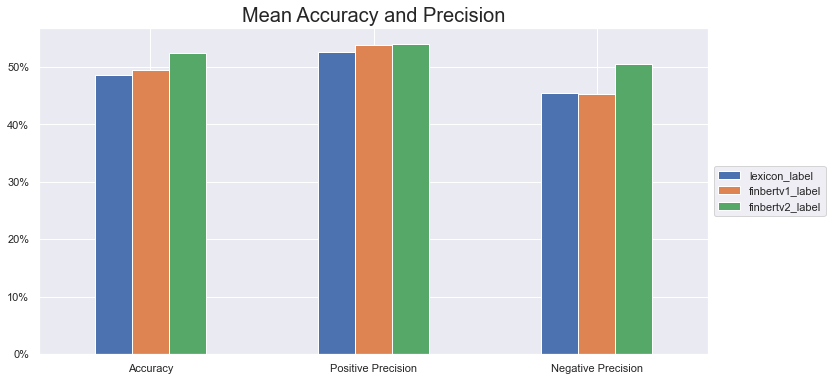

In [16]:
ax = (
    summary_df.stack(["metric", "feature"])
    .groupby(["metric", "feature"])
    .mean()
    .loc[["accuracy", "pos_prec", "neg_prec"]]
    .unstack()[["lexicon_label", "finbertv1_label", "finbertv2_label"]]
    .rename(index={"accuracy":"Accuracy", "pos_prec":"Positive Precision", "neg_prec":"Negative Precision"})
    .plot.bar(figsize=(12, 6), title="Mean Accuracy and Precision")
)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.title.set_size(20)
ax.set_xlabel('')
plt.xticks(rotation='horizontal')

## Accuracy vs Holding Period

(array([0, 1, 2]),
 [Text(0, 0, 'lexicon_label'),
  Text(1, 0, 'finbertv1_label'),
  Text(2, 0, 'finbertv2_label')])

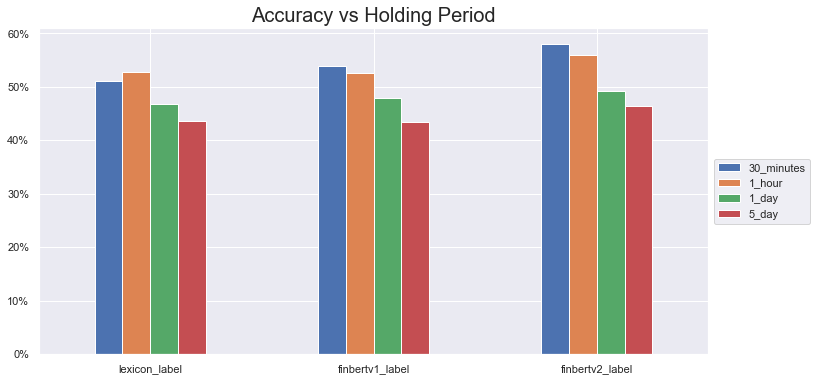

In [17]:
ax = (
    summary_df["accuracy"].T
    .plot.bar(figsize=(12, 6), title="Accuracy vs Holding Period")
)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.title.set_size(20)
ax.set_xlabel('')
plt.xticks(rotation='horizontal')

## FinBERT v2 classification threshold

In [18]:
threshold_df = target_df.copy()

In [19]:
for thres in [0.6, 0.7, 0.8, 0.9]:
    threshold_df[f"finbertv2_label_{thres}"] = threshold_df.apply(classify_prob, pos_col='finbertv2_Positive', neg_col='finbertv2_Negative', prob_threshold=thres, axis=1)    

In [20]:
def get_result(target_df, report=False, matrix=False, debug=False):
    rows = []
    for hp in holding_period_list:
        print(hp)
        target_label_col = f'target_label_{hp}'
        target_filter_df = target_df.loc[target_df[target_label_col].isin(["pos", "neg"])].copy()
        print(target_filter_df[target_label_col].value_counts())
        for feature_col in ['finbertv2_label_0.6', 'finbertv2_label_0.7', 'finbertv2_label_0.8', 'finbertv2_label_0.9']:
            print(feature_col)
            feature_filter_df = target_filter_df.loc[target_filter_df[feature_col].isin(["pos", "neg"])]
            
            # classification report
            if report:
                print(classification_report(feature_filter_df[target_label_col], feature_filter_df[feature_col]))

            # confusion matrix
            if matrix:
                cm = confusion_matrix(feature_filter_df[target_label_col], feature_filter_df[feature_col], labels=["neg", "pos"])
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
                disp.plot()
                plt.show()

            # summary table
            report_dict = classification_report(feature_filter_df[target_label_col], feature_filter_df[feature_col], output_dict=True)
            if debug: 
                print(feature_filter_df[feature_col].value_counts())
                print(report_dict)
            neg_prec = report_dict['neg']['precision']
            neg_support = report_dict['neg']['support']
            pos_prec = report_dict['pos']['precision']
            pos_support = report_dict['pos']['support']
            acc = report_dict['accuracy']

            rows.append([hp, feature_col, neg_prec, pos_prec, neg_support, pos_support, acc])

        print()

    #  summary
    feature_order = ['finbertv2_label_0.6', 'finbertv2_label_0.7', 'finbertv2_label_0.8', 'finbertv2_label_0.9']
    metric_order = ["accuracy", "pos_prec", "neg_prec", "pos_support", "neg_support"]

    summary_df = (pd.DataFrame(rows, columns=["holding_period", "feature", "neg_prec", "pos_prec", "neg_support", "pos_support", "accuracy"])
     .set_index(["holding_period", "feature"])
     .unstack("feature")
     .reindex(index=["30_minutes", "1_hour", "1_day", "5_day"], columns=[(metric, feature) for metric in metric_order for feature in feature_order])
    )
    
    summary_df.columns.names = ["metric", "feature"]
    
    return summary_df

# summary_df = get_result(target_df, report=False, matrix=False)
# summary_df = get_result(target_df.loc[target_df["news_category"].isin(["others"])], report=False, matrix=False)

source = ['The Street', 'Others', 'Associated Press', 'CNBC', 'Reuters', 'GlobeNewswire', 'Wall Street Journal']
summary_threshold_df = get_result(threshold_df.loc[target_df["source"].isin(source)], report=False, matrix=False)

30_minutes
pos    537
neg    492
Name: target_label_30_minutes, dtype: int64
finbertv2_label_0.6
finbertv2_label_0.7
finbertv2_label_0.8
finbertv2_label_0.9

1_hour
pos    538
neg    487
Name: target_label_1_hour, dtype: int64
finbertv2_label_0.6
finbertv2_label_0.7
finbertv2_label_0.8
finbertv2_label_0.9

1_day
pos    555
neg    554
Name: target_label_1_day, dtype: int64
finbertv2_label_0.6
finbertv2_label_0.7
finbertv2_label_0.8
finbertv2_label_0.9

5_day
neg    550
pos    542
Name: target_label_5_day, dtype: int64
finbertv2_label_0.6
finbertv2_label_0.7
finbertv2_label_0.8
finbertv2_label_0.9



In [21]:
summary_threshold_df

metric                    accuracy                                          \
feature        finbertv2_label_0.6 finbertv2_label_0.7 finbertv2_label_0.8   
holding_period                                                               
30_minutes                0.573930            0.576238            0.580972   
1_hour                    0.553875            0.557060            0.560396   
1_day                     0.489796            0.491319            0.492806   
5_day                     0.468917            0.464610            0.465291   

metric                                        pos_prec                      \
feature        finbertv2_label_0.9 finbertv2_label_0.6 finbertv2_label_0.7   
holding_period                                                               
30_minutes                0.584034            0.580756            0.587413   
1_hour                    0.562628            0.569536            0.580205   
1_day                     0.495345            0.493976            0.500000   
5_day                     0.463938            0.510067            0.511864   

metric                                                            neg_prec  \
feature        finbertv2_label_0.8 finbertv2_label_0.9 finbertv2_label_0.6   
holding_period                                                               
30_minutes                0.587189            0.588889            0.565022   
1_hour                    0.579861            0.578182            0.533040   
1_day                     0.492163            0.493506            0.484375   
5_day                     0.503472            0.501818            0.422642   

metric                                                                      \
feature        finbertv2_label_0.7 finbertv2_label_0.8 finbertv2_label_0.9   
holding_period                                                               
30_minutes                0.561644            0.572770            0.577670   
1_hour                    0.526786            0.534562            0.542453   
1_day                     0.480000            0.493671            0.497817   
5_day                     0.410156            0.420408            0.420168   

metric                 pos_support                                          \
feature        finbertv2_label_0.6 finbertv2_label_0.7 finbertv2_label_0.8   
holding_period                                                               
30_minutes                     266                 264                 256   
1_hour                         278                 276                 268   
1_day                          296                 293                 277   
5_day                          305                 302                 287   

metric                                     neg_support                      \
feature        finbertv2_label_0.9 finbertv2_label_0.6 finbertv2_label_0.7   
holding_period                                                               
30_minutes                     246                 248                 241   
1_hour                         256                 251                 241   
1_day                          267                 292                 283   
5_day                          276                 258                 249   

metric                                                  
feature        finbertv2_label_0.8 finbertv2_label_0.9  
holding_period                                          
30_minutes                     238                 230  
1_hour                         237                 231  
1_day                          279                 270  
5_day                          246                 237

(array([0, 1, 2]),
 [Text(0, 0, 'Accuracy'),
  Text(1, 0, 'Positive Precision'),
  Text(2, 0, 'Negative Precision')])

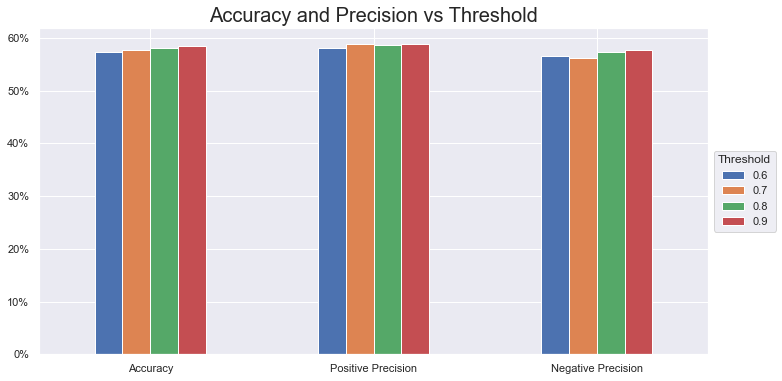

In [22]:
long_df = summary_threshold_df.stack(level=["metric", "feature"]).reset_index()
long_df["threshold"] = long_df.feature.str.split("_", expand=True)[2]

ax = (long_df.loc[long_df["holding_period"] == "30_minutes"]
      .set_index(["metric", "threshold"])
      .unstack()[0].loc[["accuracy", "pos_prec", "neg_prec"]]
      .rename(index={"accuracy":"Accuracy", "pos_prec":"Positive Precision", "neg_prec":"Negative Precision"})
      .plot.bar(title="Accuracy and Precision vs Threshold", figsize=(12, 6))
     )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Threshold")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.title.set_size(20)
ax.set_xlabel('')
plt.xticks(rotation='horizontal')

## Error analysis

In [23]:
target_df.loc[37579]["summary"]

"Albemarle Corp ( NYSE: ALB ) shares are trading higher in Monday's after-hours session after the company raised its full-year 2022 guidance. Albemarle said it revised its guidance higher primarily due to the completion of additional lithium contract renegotiations following the company's first-qua"

In [24]:
target_df.loc[(target_df["finbertv2_label"] == target_df["target_label_30_minutes"]) &
              (target_df["finbertv2_label"] != target_df["lexicon_label"]) & 
             (target_df["target_label_30_minutes"] != "neu")].sample(10)

,index,title,url,time_published,authors,summary,banner_image,source,category_within_source,source_domain,topics,overall_sentiment_score,overall_sentiment_label,ticker_sentiment,company,symbol,relevance_score,ticker_sentiment_score,ticker_sentiment_label,model_input,lexicon_neg,lexicon_neu,lexicon_pos,lexicon_compound,finbertv1_negative,finbertv1_neutral,finbertv1_positive,finbertv2_Negative,finbertv2_Neutral,finbertv2_Positive,time_published_hold,time_published_before,time_published_after_30_minutes,time_published_after_1_hour,time_published_after_1_day,time_published_after_5_day,price_before,price_after_30_minutes,price_after_1_hour,price_after_1_day,price_after_5_day,pct_return_30_minutes,pct_return_1_hour,pct_return_1_day,pct_return_5_day,target_label_30_minutes,target_label_1_hour,target_label_1_day,target_label_5_day,lexicon_label,finbertv1_label,finbertv2_label,finbertv1_compound,finbertv2_compound
65837,173158,Generac Price Target Slashed By ~7% At Keybanc,https://www.benzinga.com/news/22/07/28157576/generac-price-target-slashed-by-7-at-keybanc,2022-07-21 18:47:02,['Akanksha Bakshi'],Keybanc analyst Jeffrey D. Hammond lowered the price target on Generac Holdings Inc. GNRC to $325 ( an upside of 30% ) from $350 while maintaining the Overweight rating on the shares. The analyst says that the dealers communicated a mixed picture as the outlook became unclear.,https://cdn.benzinga.com/files/images/story/2022/07/21/industrial_pic_6.jpg?optimize=medium&dpr=2&auto=webp&width=3840,Benzinga,News,www.benzinga.com,"[{'topic': 'Economy - Fiscal', 'relevance_score': '0.158519'}, {'topic': 'Financial Markets', 'relevance_score': '0.108179'}, {'topic': 'Manufacturing', 'relevance_score': '0.5'}, {'topic': 'Earnings', 'relevance_score': '0.158519'}, {'topic': 'Finance', 'relevance_score': '0.5'}]",-0.009801,Neutral,"[{'ticker': 'GNRC', 'relevance_score': '0.640349', 'ticker_sentiment_score': '-0.129989', 'ticker_sentiment_label': 'Neutral'}, {'ticker': 'JPM', 'relevance_score': '0.181137', 'ticker_sentiment_score': '-0.015051', 'ticker_sentiment_label': 'Neutral'}]",Generac Holdings Inc.,GNRC,0.640349,-0.129989,Neutral,Keybanc analyst Jeffrey D. Hammond lowered the price target on Generac Holdings Inc. GNRC to $325 ( an upside of 30% ) from $350 while maintaining the Overweight rating on the shares. The analyst says that the dealers communicated a mixed picture as the outlook became unclear.,0.000,1.000,0.000,0.0,0.937107,0.037178,0.025715,9.999789e-01,3.764197e-06,1.733933e-05,2022-07-26 18:47:02,2022-07-21 18:45:00,2022-07-21 19:20:00,2022-07-21 19:50:00,2022-07-22 18:50:00,2022-07-26 18:50:00,249.880000,247.800000,247.800000,237.000000,233.970000,-0.008324,-0.008324,-0.051545,-0.063671,neg,neg,neg,neg,neu,neg,neg,-0.911392,-0.999962
27669,69838,"Futures Split: Tesla, EV Chip Plays Tumble; CRM Soars",https://www.investors.com/market-trend/stock-market-today/dow-jones-futures-tesla-investor-day-tsla-stock-salesforce-stock-soars/,2023-03-02 13:14:00,"['ED CARSON', ""Investor's Business Daily""]","Dow Jones Futures Rise: Tesla, EV Chip Plays Tumble After Investor ... Investor's Business Daily ...",https://www.investors.com/wp-content/uploads/2021/01/Stock-Tesla-modelY-01-adobe.jpg,Investors Business Daily,NaN,www.investors.com,"[{'topic': 'Life Sciences', 'relevance_score': '0.25'}, {'topic': 'Financial Markets', 'relevance_score': '1.0'}, {'topic': 'Manufacturing', 'relevance_score': '0.25'}, {'topic': 'Earnings', 'relevance_score': '0.976913'}, {'topic': 'Energy & Transportation', 'relevance_score': '0.25'}, {'topic': 'Technology', 'relevance_score': '0.25'}]",-0.014415,Neutral,"[{'ticker': 'NVDA', 'relevance_score': '0.052918', 'ticker_sentiment_score': '-0.136641', 'ticker_sentiment_label': 'Neutral'}, {'ticker': 'AAPL', 'relevance_score': '0.079304', 'ticker_sentiment_score': '-0.143404', 'ticker_sentiment_label': 'Neutral'}, {'ticker': 'MP', 'relevance_score': '0.052918', 'ticker_sentiment_score': '-0.175681', 'ticker_sentiment_la

In [25]:
# filter_df = target_df.loc[target_df["news_category"].isin(["others"])].copy()

source = ['The Street', 'Others', 'Associated Press', 'CNBC', 'Reuters', 'GlobeNewswire', 'Wall Street Journal']
filter_df = target_df.loc[target_df["source"].isin(source)].copy()

In [26]:
source_dist = filter_df["source"].value_counts()
majority_source = source_dist.loc[source_dist > 100].index

filter_df["source_mapped"] = np.where(filter_df["source"].isin(majority_source), filter_df["source"], "Others")

In [27]:
# s_dict = {}
# for cat in news_category:
#     try:
#         s = get_result(target_df.loc[target_df["news_category"] == cat], debug=False)
#         s_dict[cat] = s
#     except KeyError:
#         continue
        
        
s_dict = {}
for source in filter_df["source_mapped"].unique():
    print(source)
    try:
        s = get_result(filter_df.loc[filter_df["source_mapped"] == source], debug=False)
        s_dict[source] = s
    except KeyError:
        continue

Reuters
30_minutes
pos    63
neg    45
Name: target_label_30_minutes, dtype: int64
finbertv2_label_0.6
The Street
30_minutes
neg    235
pos    228
Name: target_label_30_minutes, dtype: int64
finbertv2_label_0.6
Wall Street Journal
30_minutes
pos    31
neg    28
Name: target_label_30_minutes, dtype: int64
finbertv2_label_0.6
CNBC
30_minutes
neg    61
pos    60
Name: target_label_30_minutes, dtype: int64
finbertv2_label_0.6
GlobeNewswire
30_minutes
pos    34
neg    29
Name: target_label_30_minutes, dtype: int64
finbertv2_label_0.6
Associated Press
30_minutes
pos    121
neg     94
Name: target_label_30_minutes, dtype: int64
finbertv2_label_0.6


In [28]:
for key, s_df in s_dict.items():
    print(key)
    print(s_df.to_string())
    
    print()

In [29]:
filter_1 = (target_df["title"].str.match("(Are You a (Growth|Value|Momentum) Investor|Are You Looking for a High-Growth Dividend Stock|Why This 1 (Growth|Value|Momentum) Stock).*"))
filter_2 = (target_df["title"].str.match(".*(: Which Stock Is the Better Value Option|Which Is the Better Value Stock Right Now|Is Still a Bargain Stock|Here Is Why Bargain Hunters Would Love|Which Stock Should Value Investors Buy Now)"))
filter_3 = (target_df["title"].str.match(".*(Dips More Than Broader Markets|Gains As Market Dips|Gains But Lags Market|Stock Sinks As Market Gains|Outpaces Stock Market Gains): What You Should Know.*"))
filter_4 = (target_df["title"].str.match(".*(Check Out What Whales Are Doing With|What Are Whales Doing With|Whale Trades Spotted|Looking At.*Recent Whale Trades|This Is What Whales Are Betting On|Unusual Options Activity).*"))
filter_5 = (target_df["title"].str.match(".*(and Other Stocks to Watch This Week|and (Other|More) Stocks for Investors to Watch This Week)"))
filter_6 = target_df["title"].str.match(".*(Better Buy:.*vs.*).*")

filter_df.loc[filter_1 | filter_2 | filter_3 | filter_4 | filter_5 | filter_6, "title"].value_counts()

Series([], Name: title, dtype: int64)

In [30]:
target_df1 = target_df.loc[target_df["title"].str.match("Is.*A Better Pick Over.*\?")]

target_df1 = target_df.loc[target_df["title"].str.match(".*Stock(s?) to Buy for the Long Haul")]

# target_df1 = target_df.loc[target_df["source"] == "The Street"]

target_df1

# get_result(target_df1)

,index,title,url,time_published,authors,summary,banner_image,source,category_within_source,source_domain,topics,overall_sentiment_score,overall_sentiment_label,ticker_sentiment,company,symbol,relevance_score,ticker_sentiment_score,ticker_sentiment_label,model_input,lexicon_neg,lexicon_neu,lexicon_pos,lexicon_compound,finbertv1_negative,finbertv1_neutral,finbertv1_positive,finbertv2_Negative,finbertv2_Neutral,finbertv2_Positive,time_published_hold,time_published_before,time_published_after_30_minutes,time_published_after_1_hour,time_published_after_1_day,time_published_after_5_day,price_before,price_after_30_minutes,price_after_1_hour,price_after_1_day,price_after_5_day,pct_return_30_minutes,pct_return_1_hour,pct_return_1_day,pct_return_5_day,target_label_30_minutes,target_label_1_hour,target_label_1_day,target_label_5_day,lexicon_label,finbertv1_label,finbertv2_label,finbertv1_compound,finbertv2_compound
1046,3135,MO: The Smartest Tobacco Stock to Buy for the Long Haul,https://stocknews.com/news/mo-japay-imbby-vgr-the-smartest-tobacco-stock-to-buy-for-the-long-haul/,2022-07-29 19:26:09,[],"Altria Group, Inc. ( MO ) manufactures and sells smokable and oral tobacco products in the United States. The company provides cigarettes primarily under the Marlboro brand. cigars and pipe tobacco principally under the Black & Mild brand.",https://stocknews.com/wp-content/uploads/2021/04/shutterstock_360829724-1-scaled.jpg,Stocknews.com,NaN,stocknews.com,"[{'topic': 'Earnings', 'relevance_score': '0.94762'}, {'topic': 'Financial Markets', 'relevance_score': '0.266143'}, {'topic': 'Manufacturing', 'relevance_score': '1.0'}]",0.165990,Somewhat-Bullish,"[{'ticker': 'VGR', 'relevance_score': '0.125789', 'ticker_sentiment_score': '-0.073818', 'ticker_sentiment_label': 'Neutral'}, {'ticker': 'MO', 'relevance_score': '0.696531', 'ticker_sentiment_score': '0.224016', 'ticker_sentiment_label': 'Somewhat-Bullish'}, {'ticker': 'JAPAF', 'relevance_score': '0.063091', 'ticker_sentiment_score': '-0.064018', 'ticker_sentiment_label': 'Neutral'}]",Altria Group Inc.,MO,0.696531,0.224016,Somewhat-Bullish,"Altria Group, Inc. ( MO ) manufactures and sells smokable and oral tobacco products in the United States. The company provides cigarettes primarily under the Marlboro brand. cigars and pipe tobacco principally under the Black & Mild brand.",0.0,1.000,0.000,0.00,0.020559,0.952052,0.027389,7.778285e-06,9.999893e-01,0.000003,2022-08-03 19:26:09,2022-07-29 19:25:00,2022-07-29 20:00:00,2022-07-29 20:30:00,2022-07-30 19:30:00,2022-08-03 19:30:00,41.138129,40.753573,40.753573,40.753573,41.485167,-0.009348,-0.009348,-0.009348,0.008436,neg,neg,neu,neu,neu,neu,neu,0.006830,-0.000005
18360,42323,2 Top Tech Stocks to Buy for the Long Haul,https://www.fool.com/investing/2022/03/08/apple-alphabet-top-tech-stocks-to-buy/,2022-03-08 11:12:00,['Parkev Tatevosian'],The power of compounding works better the more time it is given.,https://g.foolcdn.com/image/?url=https%3A%2F%2Fg.foolcdn.com%2Feditorial%2Fimages%2F669129%2Fgettyimages-1309050920.jpg&w=700&op=resize,Motley Fool,NaN,www.fool.com,"[{'topic': 'Earnings', 'relevance_score': '0.650727'}, {'topic': 'Technology', 'relevance_score': '1.0'}, {'topic': 'Financial Markets', 'relevance_score': '0.161647'}]",0.167203,Somewhat-Bullish,"[{'ticker': 'GOOG', 'relevance_score': '0.304396', 'ticker_sentiment_score': '-0.165284', 'ticker_sentiment_label': 'Somewhat-Bearish'}, {'ticker': 'AAPL', 'relevance_score': '0.621324', 'ticker_sentiment_score': '0.520191', 'ticker_sentiment_label': 'Bullish'}]",Apple Inc.,AAPL,0.621324,0.520191,Bullish,The power of compounding works better the more time it is given.,0.0,0.846,0.154,0.25,0.018433,0.770739,0.210828,4.675975e-07,1.542602e-06,0.999998,2022-03-13 11:12:00,2022-03-08 11:10:00,2022-03-08 11:45:00,2022-03-08 12:15:00,2022-03-09 11:15:00,2022-03-13 11:15:00,156.344921,154.845900,158.429652,160.057728,153.207897,-0.009588,0.013334,0.023748,-0.020065,neg,pos,pos,neu,pos,neu,pos,0.192396

In [31]:
filter_df.loc[~ (filter_1 | filter_2 | filter_3 | filter_4 | filter_5 | filter_6)].groupby(["source", "title"]).count()["url"].sort_values(ascending=False).head(20)

source            title                                                                                               
CNBC              Stocks could stay choppy as fears about the Fed overshadow earnings news                                12
                  Seasonal trends could be a drag on a stock market that needs a rebound                                   8
The Street        Nvidia and AMD Among Bank of America Favorite Chip Stocks                                                7
                  Netflix Makes J.P Morgan's List of Pullback Stocks                                                       6
                  Cramer's Mad Money Recap 4/13: Delta, JPMorgan, Disney                                                   5
                  AMD Extends Data Center Drive With $1.9 Billion Purchase of Cloud Startup Pensando                       4
                  AAP Team Lauds Deere Amid High Agriculture Prices                                                        4
      

In [32]:
# check false positive for finbert_v2
filter_df.loc[(filter_df["finbertv2_label"]=="pos") & (filter_df["target_label_30_minutes"]=="neg")].groupby(["title", "source"]).count()["url"].sort_values(ascending=False).head(20)

title                                                                                             source             
AAP Team Lauds Deere Amid High Agriculture Prices                                                 The Street             2
What is Wells Fargo's Favorite Bank Stock?                                                        The Street             2
Wells Fargo Is Bullish on These Two Credit-Card Titans                                            The Street             2
Nike beats revenue estimates on strong demand for sneakers                                        Reuters                1
Saudi Aramco Posts Record Quarterly Profit on Surging Oil Prices                                  Wall Street Journal    1
Royal Caribbean, Carnival Cruise Lines Hit a Pandemic Comeback Milestone                          The Street             1
Royal Caribbean Makes Big Deal to Fix a Passenger Pain Point                                      The Street             1
Pioneer Natural Resou